In [1]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))

TF: 2.19.0
GPU: []


In [2]:
VOCAB_SIZE = 20000
MAXLEN = 250
EMB_DIM = 128

# Load tokenized IMDB dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

# Pad sequences
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAXLEN, padding="post", truncating="post")
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=MAXLEN, padding="post", truncating="post")

print("Train padded:", x_train.shape)
print("Test padded :", x_test.shape)

# Create validation split
VAL_FRAC = 0.2
n_val = int(len(x_train) * VAL_FRAC)

x_val, y_val = x_train[:n_val], y_train[:n_val]
x_tr,  y_tr  = x_train[n_val:], y_train[n_val:]

print("Train split:", x_tr.shape, y_tr.shape)
print("Val split  :", x_val.shape, y_val.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (25000,) (25000,)
Test : (25000,) (25000,)
Train padded: (25000, 250)
Test padded : (25000, 250)
Train split: (20000, 250) (20000,)
Val split  : (5000, 250) (5000,)


In [3]:
# Decode example review
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

def decode_review(seq):
    # Keras IMDB reserves: 0 (pad), 1 (start), 2 (unk), 3 (unused)
    words = []
    for i in seq:
        if i == 0:
            continue
        w = reverse_word_index.get(i - 3, "<UNK>")
        words.append(w)
    return " ".join(words)

idx = 0
print("Label:", y_tr[idx])
print(decode_review(x_tr[idx][:80]))


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Label: 0
<UNK> i think this could've been a decent movie and some of its parts are ok but in whole it's a b movie same about the plot parts are ok but it has several holes and oddities that doesn't quite add up acting is mostly ok i've seen worse of this too br br the beginning sets the level with cars driving in the desert making cool but totally unnecessary jumps through some small <UNK> in slow motion cool like


In [4]:
def build_common_compile(model, lr=1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model

def plot_history(hist, title="Model"):
    h = hist.history
    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"{title}: Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(7,4))
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"{title}: Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()
    plt.show()

    # AUC
    plt.figure(figsize=(7,4))
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"{title}: AUC")
    plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.grid(True); plt.legend()
    plt.show()

def train_model(model, name, epochs=10, batch_size=128):
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_auc", patience=2, mode="max", restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6),
    ]
    print(f"\n===== TRAIN: {name} =====")
    hist = model.fit(
        x_tr, y_tr,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    plot_history(hist, name)
    return hist

def evaluate_model(model, name):
    print(f"\n===== TEST EVAL: {name} =====")
    test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{name} | loss={test_loss:.4f} acc={test_acc:.4f} auc={test_auc:.4f}")

    y_prob = model.predict(x_test, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4, target_names=["negative", "positive"]))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg","pos"])
    plt.figure(figsize=(5,5))
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    return {"model": name, "loss": test_loss, "accuracy": test_acc, "auc": test_auc}

In [5]:
def make_rnn():
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.2),
        layers.SimpleRNN(64),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ], name="SimpleRNN")
    return build_common_compile(model, lr=1e-3)

def make_lstm():
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.2),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ], name="LSTM")
    return build_common_compile(model, lr=1e-3)

def make_bilstm():
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(0.35),
        layers.Dense(1, activation="sigmoid")
    ], name="BiLSTM")
    return build_common_compile(model, lr=1e-3)

def make_deep_bilstm():
    # Deep + bidirectional
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.25),

        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.30),

        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.35),

        layers.Dense(64, activation="relu"),
        layers.Dropout(0.35),
        layers.Dense(1, activation="sigmoid")
    ], name="Deep_BiLSTM")
    return build_common_compile(model, lr=1e-3)

models = [
    make_rnn(),
    make_lstm(),
    make_bilstm(),
    make_deep_bilstm(),
]

for m in models:
    print(m.name)
    m.summary()
    print("-"*60)

SimpleRNN


Model: "SimpleRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,572,417 (9.81 MB)

 Trainable params: 2,572,417 (9.81 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------
LSTM


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,609,473 (9.95 MB)

 Trainable params: 2,609,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------
BiLSTM


Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------
Deep_BiLSTM


Model: "Deep_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 250, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704,257 (10.32 MB)

 Trainable params: 2,704,257 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------


In [6]:
def make_rnn():
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.2),
        layers.SimpleRNN(64),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ], name="SimpleRNN")
    return build_common_compile(model, lr=1e-3)

def make_lstm():
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.2),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ], name="LSTM")
    return build_common_compile(model, lr=1e-3)

def make_bilstm():
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(0.35),
        layers.Dense(1, activation="sigmoid")
    ], name="BiLSTM")
    return build_common_compile(model, lr=1e-3)

def make_deep_bilstm():
    # Deep + bidirectional: stack with return_sequences=True on first recurrent layer
    model = keras.Sequential([
        layers.Input(shape=(MAXLEN,)),
        layers.Embedding(VOCAB_SIZE, EMB_DIM),
        layers.SpatialDropout1D(0.25),

        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.30),

        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.35),

        layers.Dense(64, activation="relu"),
        layers.Dropout(0.35),
        layers.Dense(1, activation="sigmoid")
    ], name="Deep_BiLSTM")
    return build_common_compile(model, lr=1e-3)

models = [
    make_rnn(),
    make_lstm(),
    make_bilstm(),
    make_deep_bilstm(),
]

for m in models:
    print(m.name)
    m.summary()
    print("-"*60)

SimpleRNN


Model: "SimpleRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,572,417 (9.81 MB)

 Trainable params: 2,572,417 (9.81 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------
LSTM


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,609,473 (9.95 MB)

 Trainable params: 2,609,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------
BiLSTM


Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------
Deep_BiLSTM


Model: "Deep_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_7             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 250, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704,257 (10.32 MB)

 Trainable params: 2,704,257 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------



===== TRAIN: SimpleRNN =====
Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.5035 - auc: 0.5008 - loss: 0.6999 - val_accuracy: 0.5020 - val_auc: 0.4962 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - accuracy: 0.6012 - auc: 0.6550 - loss: 0.6610 - val_accuracy: 0.5068 - val_auc: 0.5085 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step - accuracy: 0.6502 - auc: 0.7406 - loss: 0.5837 - val_accuracy: 0.5008 - val_auc: 0.5084 - val_loss: 0.7340 - learning_rate: 5.0000e-04
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.6898 - auc: 0.7961 - loss: 0.5226 - val_accuracy: 0.4932 - val_auc: 0.5038 - val_loss: 0.7513 - learning_rate: 2.5000e-04


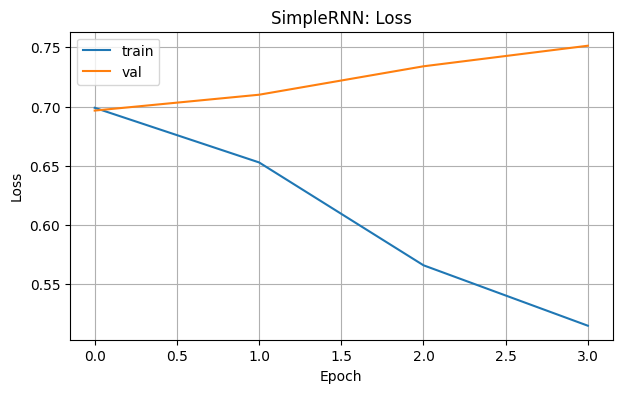

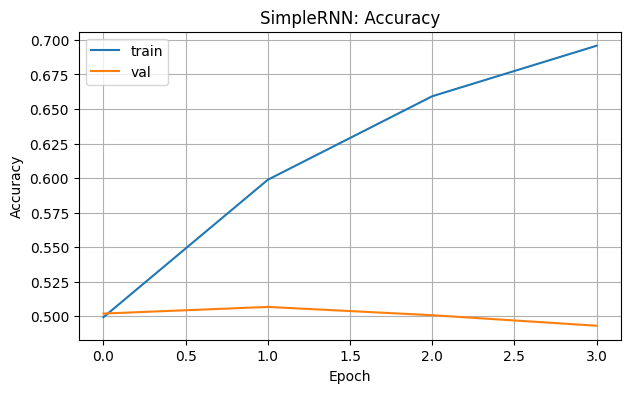

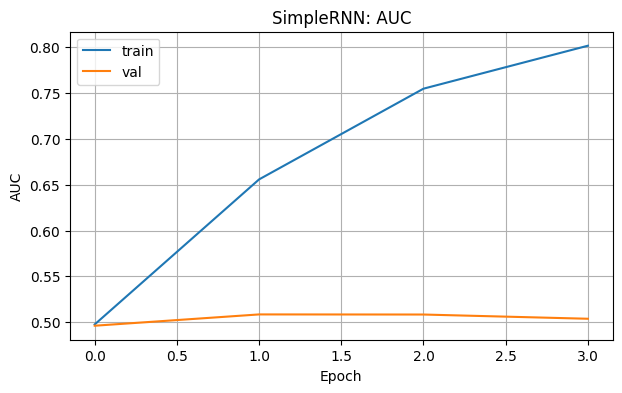


===== TEST EVAL: SimpleRNN =====
SimpleRNN | loss=0.7095 acc=0.5050 auc=0.5065

Classification report:
              precision    recall  f1-score   support

    negative     0.5060    0.4225    0.4605     12500
    positive     0.5043    0.5875    0.5427     12500

    accuracy                         0.5050     25000
   macro avg     0.5051    0.5050    0.5016     25000
weighted avg     0.5051    0.5050    0.5016     25000



<Figure size 500x500 with 0 Axes>

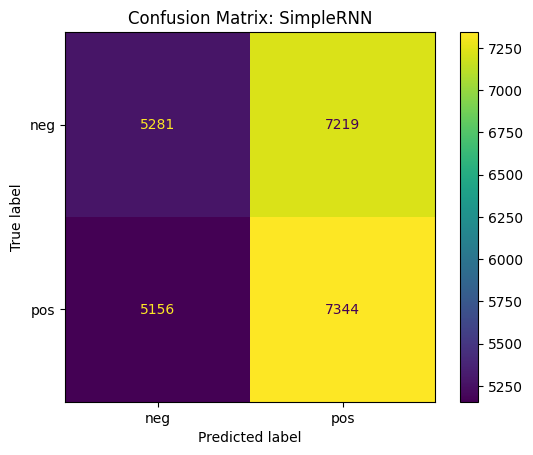


===== TRAIN: LSTM =====
Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 93s 573ms/step - accuracy: 0.5029 - auc: 0.5021 - loss: 0.6935 - val_accuracy: 0.5204 - val_auc: 0.5241 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 146s 596ms/step - accuracy: 0.5511 - auc: 0.5709 - loss: 0.6955 - val_accuracy: 0.5358 - val_auc: 0.5564 - val_loss: 0.6846 - learning_rate: 0.0010
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 570ms/step - accuracy: 0.5815 - auc: 0.6407 - loss: 0.6481 - val_accuracy: 0.5728 - val_auc: 0.6382 - val_loss: 0.6499 - learning_rate: 0.0010
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 566ms/step - accuracy: 0.6148 - auc: 0.6988 - loss: 0.5879 - val_accuracy: 0.5692 - val_auc: 0.6230 - val_loss: 0.7064 - learning_rate: 0.0010
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 561ms/step - accuracy: 0.6455 - auc: 0.7439 - loss: 0.5376 - val_accuracy: 0.6008 - val_auc: 0.6840 - val_loss: 0.6713 - learning_rate: 5.0000e-04
Epoch 6/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 8

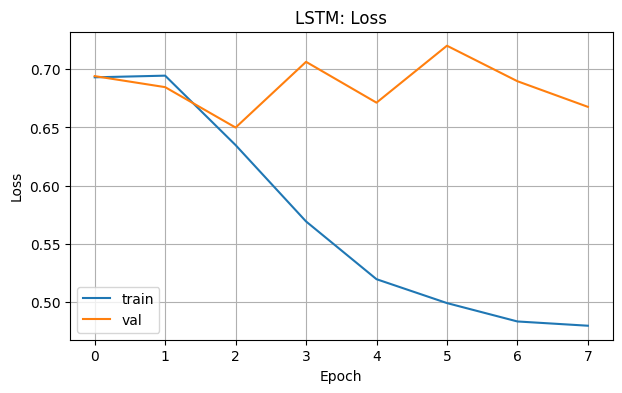

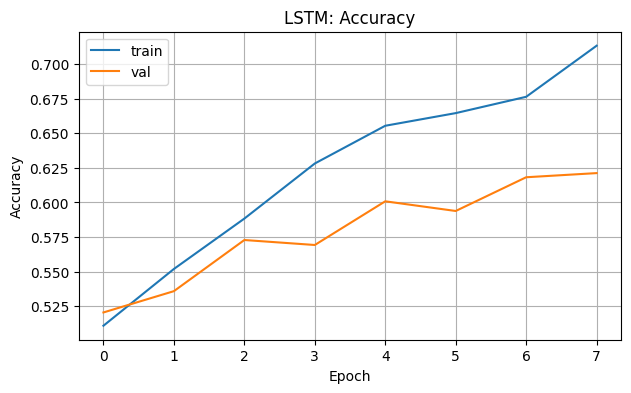

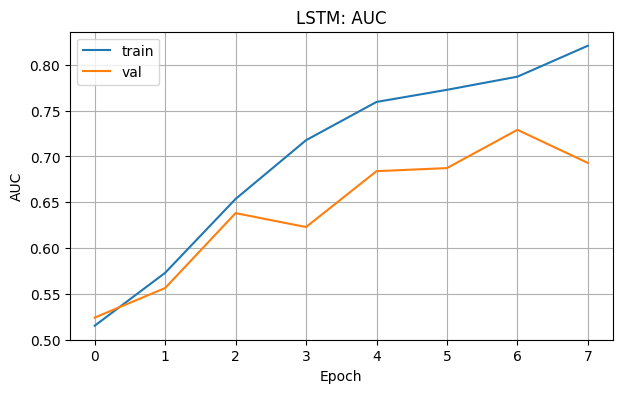


===== TEST EVAL: LSTM =====
LSTM | loss=0.7212 acc=0.6023 auc=0.7012

Classification report:
              precision    recall  f1-score   support

    negative     0.7954    0.2755    0.4093     12500
    positive     0.5619    0.9291    0.7003     12500

    accuracy                         0.6023     25000
   macro avg     0.6786    0.6023    0.5548     25000
weighted avg     0.6786    0.6023    0.5548     25000



<Figure size 500x500 with 0 Axes>

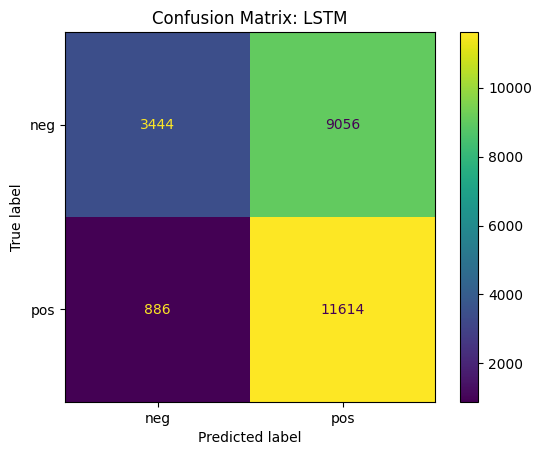


===== TRAIN: BiLSTM =====
Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.6235 - auc: 0.6835 - loss: 0.6201 - val_accuracy: 0.7976 - val_auc: 0.8731 - val_loss: 0.4568 - learning_rate: 0.0010
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8603 - auc: 0.9238 - loss: 0.3495 - val_accuracy: 0.8492 - val_auc: 0.9195 - val_loss: 0.3658 - learning_rate: 0.0010
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9177 - auc: 0.9638 - loss: 0.2333 - val_accuracy: 0.8514 - val_auc: 0.9260 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9517 - auc: 0.9828 - loss: 0.1506 - val_accuracy: 0.8694 - val_auc: 0.9326 - val_loss: 0.4477 - learning_rate: 5.0000e-04
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9666 - auc: 0.9901 - loss: 0.1092 - val_accuracy: 0.8666 - val_auc: 0.9320 - val_loss: 0.4239 - learning_rate: 2.5000e-04
Epoch 6/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 160s 1

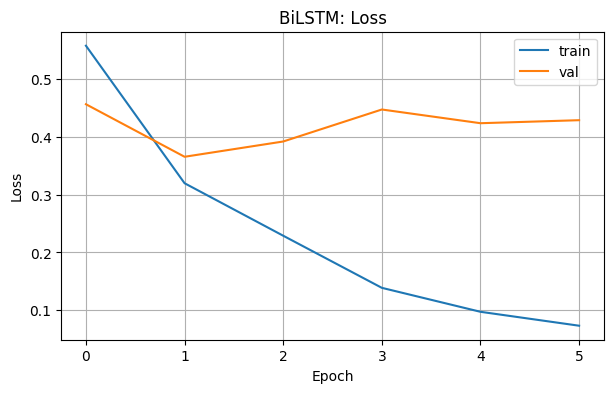

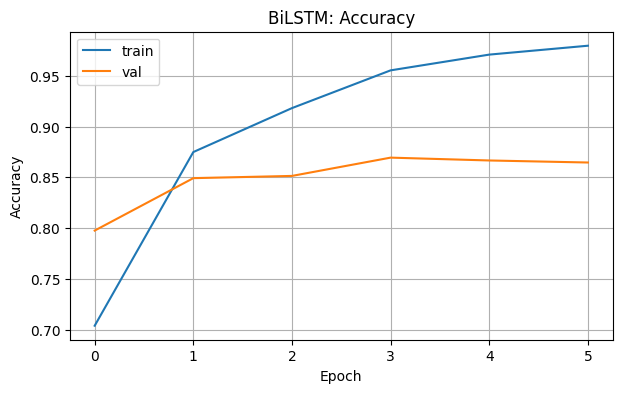

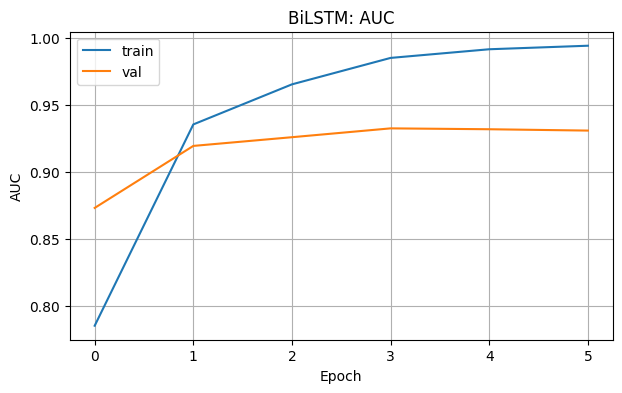


===== TEST EVAL: BiLSTM =====
BiLSTM | loss=0.5406 acc=0.8380 auc=0.9135

Classification report:
              precision    recall  f1-score   support

    negative     0.8088    0.8852    0.8453     12500
    positive     0.8732    0.7908    0.8300     12500

    accuracy                         0.8380     25000
   macro avg     0.8410    0.8380    0.8376     25000
weighted avg     0.8410    0.8380    0.8376     25000



<Figure size 500x500 with 0 Axes>

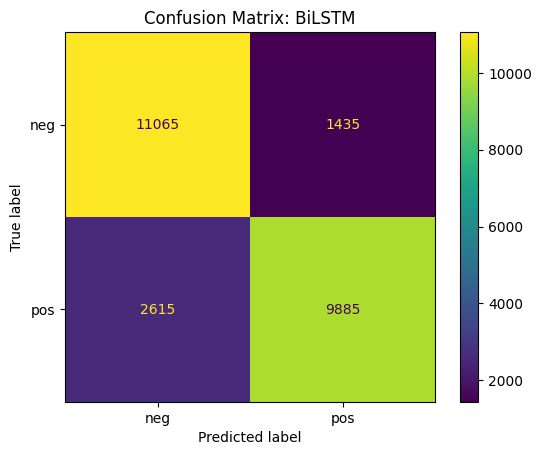


===== TRAIN: Deep_BiLSTM =====
Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.6095 - auc: 0.6634 - loss: 0.6263 - val_accuracy: 0.8524 - val_auc: 0.9285 - val_loss: 0.3487 - learning_rate: 0.0010
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8789 - auc: 0.9413 - loss: 0.3074 - val_accuracy: 0.8730 - val_auc: 0.9379 - val_loss: 0.3753 - learning_rate: 0.0010
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9347 - auc: 0.9765 - loss: 0.1850 - val_accuracy: 0.8730 - val_auc: 0.9405 - val_loss: 0.4228 - learning_rate: 5.0000e-04
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9617 - auc: 0.9887 - loss: 0.1205 - val_accuracy: 0.8688 - val_auc: 0.9371 - val_loss: 0.4702 - learning_rate: 2.5000e-04
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9755 - auc: 0.9914 - loss: 0.0908 - val_accuracy: 0.8686 - val_auc: 0.9378 - val_loss: 0.4688 - learning_rate: 1.2500e-04


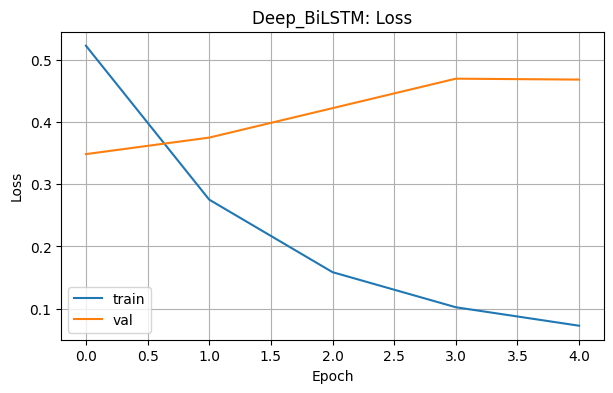

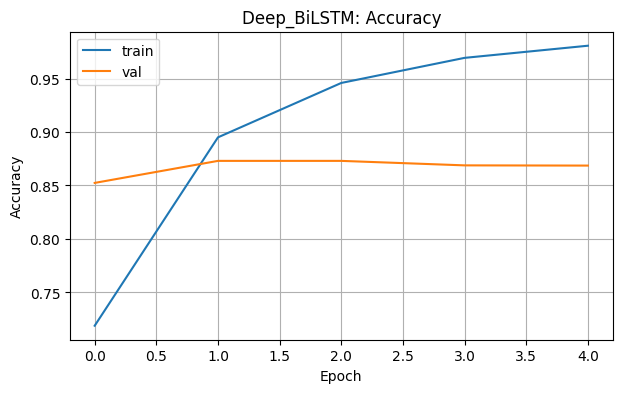

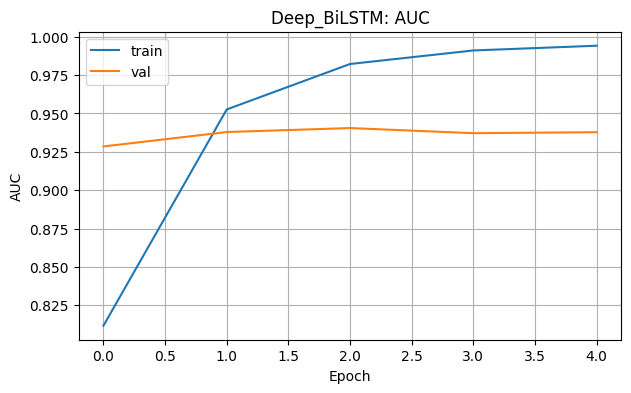


===== TEST EVAL: Deep_BiLSTM =====
Deep_BiLSTM | loss=0.5213 acc=0.8435 auc=0.9208

Classification report:
              precision    recall  f1-score   support

    negative     0.8063    0.9042    0.8524     12500
    positive     0.8909    0.7828    0.8334     12500

    accuracy                         0.8435     25000
   macro avg     0.8486    0.8435    0.8429     25000
weighted avg     0.8486    0.8435    0.8429     25000



<Figure size 500x500 with 0 Axes>

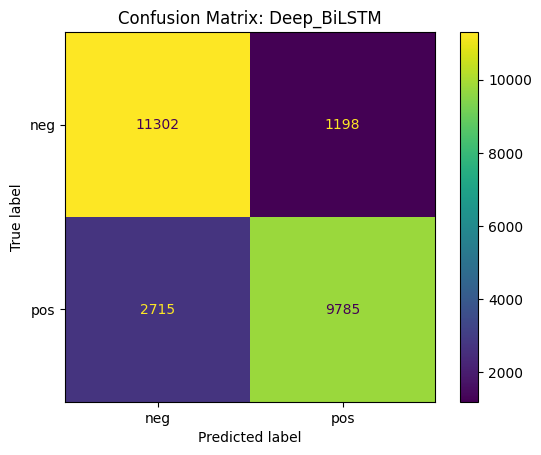

,model,loss,accuracy,auc
3,Deep_BiLSTM,0.521345,0.84348,0.920803
2,BiLSTM,0.540641,0.83800,0.913485
1,LSTM,0.721211,0.60232,0.701191
0,SimpleRNN,0.709491,0.50500,0.506508


In [7]:
results = []
histories = {}

EPOCHS = 8
BATCH  = 128

for m in models:
    hist = train_model(m, m.name, epochs=EPOCHS, batch_size=BATCH)
    histories[m.name] = hist
    results.append(evaluate_model(m, m.name))

df = pd.DataFrame(results).sort_values(by="auc", ascending=False)
df

In [8]:
best = df.iloc[0]
worst = df.iloc[-1]

print("MODEL COMPARISON")
display(df)

print("\nConclusions:")
print(f"1) The best AUC/accuracy was achieved by the model: {best['model']} "
      f"(acc={best['accuracy']:.4f}, auc={best['auc']:.4f}).")

print("2) SimpleRNN usually underperforms LSTM/Bi-LSTM because it handles long-term dependencies in text worse "
      "(vanishing/exploding gradient effect).")

print("3) LSTM is generally more stable than SimpleRNN and often provides better quality for sentiment analysis "
      "because it has 'memory' mechanisms (gates).")

print("4) Bidirectional LSTM often improves performance because it reads the sequence left-to-right and right-to-left "
      "and captures context better.")

print("5) A deeper model may further improve quality, but it risks overfitting — "
      "so Dropout/SpatialDropout, EarlyStopping, and ReduceLROnPlateau are important.")

print("\nAdditionally:")
print("- The confusion matrix shows how often the model confuses positive vs. negative reviews.")
print("- The classification report provides precision/recall/F1 for each class, which is important under class imbalance.")

MODEL COMPARISON


,model,loss,accuracy,auc
3,Deep_BiLSTM,0.521345,0.84348,0.920803
2,BiLSTM,0.540641,0.83800,0.913485
1,LSTM,0.721211,0.60232,0.701191
0,SimpleRNN,0.709491,0.50500,0.506508



Conclusions:
1) The best AUC/accuracy was achieved by the model: Deep_BiLSTM (acc=0.8435, auc=0.9208).
2) SimpleRNN usually underperforms LSTM/Bi-LSTM because it handles long-term dependencies in text worse (vanishing/exploding gradient effect).
3) LSTM is generally more stable than SimpleRNN and often provides better quality for sentiment analysis because it has 'memory' mechanisms (gates).
4) Bidirectional LSTM often improves performance because it reads the sequence left-to-right and right-to-left and captures context better.
5) A deeper model may further improve quality, but it risks overfitting — so Dropout/SpatialDropout, EarlyStopping, and ReduceLROnPlateau are important.

Additionally:
- The confusion matrix shows how often the model confuses positive vs. negative reviews.
- The classification report provides precision/recall/F1 for each class, which is important under class imbalance.
